In [44]:
import os
os.environ['GRB_LICENSE_FILE'] = '/home/victor/gurobi.lic'

import gurobipy as gp

from gurobipy import GRB, quicksum
print(gp.gurobi.version()) 
lic = gp.Env()
print(lic)

(12, 0, 2)
Set parameter Username
Set parameter LicenseID to value 2701230
Academic license - for non-commercial use only - expires 2026-08-30
<gurobipy.Env, Parameter changes: LicenseID=2701230>


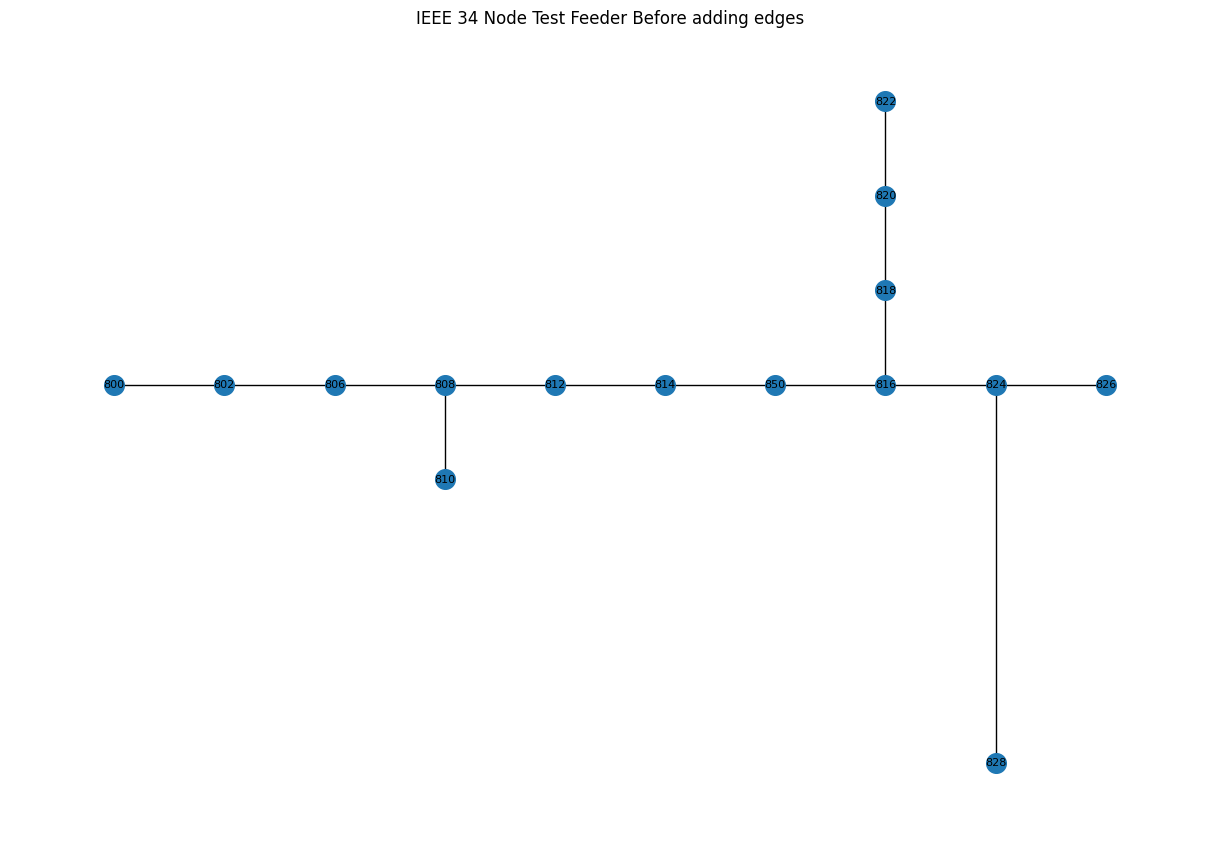

EdgesLenghts:  [(np.int64(800), np.int64(802), {'weight': np.int64(2580)}), (np.int64(802), np.int64(806), {'weight': np.int64(1730)}), (np.int64(806), np.int64(808), {'weight': np.int64(32230)}), (np.int64(808), np.int64(810), {'weight': np.int64(5804)}), (np.int64(808), np.int64(812), {'weight': np.int64(37500)}), (np.int64(812), np.int64(814), {'weight': np.int64(29730)}), (np.int64(814), np.int64(850), {'weight': np.int64(10)}), (np.int64(850), np.int64(816), {'weight': np.int64(310)}), (np.int64(816), np.int64(818), {'weight': np.int64(1710)}), (np.int64(816), np.int64(824), {'weight': np.int64(10210)}), (np.int64(818), np.int64(820), {'weight': np.int64(48150)}), (np.int64(824), np.int64(826), {'weight': np.int64(3030)}), (np.int64(824), np.int64(828), {'weight': np.int64(840)}), (np.int64(820), np.int64(822), {'weight': np.int64(13740)})]


In [45]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load feeder34 from excel file
df34 = pd.read_excel("./line_data_smaller.xls")
G34 = nx.Graph()
G123 = nx.Graph()
for _, row in df34.iterrows():
    from_node = row["Node A"]
    to_node = row["Node B"]
    length = row["Length(ft.)"]
    G34.add_edge(from_node, to_node, weight=length)

# Definir posições fixas (x,y) manualmente
pos = {
    800: (0, 0),
    802: (1, 0),
    806: (2, 0),
    808: (3, 0),
    810: (3, -1),
    812: (4, 0),
    814: (5, 0),
    816: (7, 0),
    818: (7, 1),
    820: (7, 2),
    822: (7, 3),
    824: (8, 0),
    826: (9, 0),
    828: (8, -4),
    850: (6, 0),
}


# Desenhar G34 
plt.figure(figsize=(12, 8))
nx.draw(G34, pos, with_labels=True, node_size=200, font_size=8)
plt.title("IEEE 34 Node Test Feeder Before adding edges")
plt.show()

print("EdgesLenghts: ", G34.edges(data=True))

In [46]:
def build_distance_matrix_with_virtuals(G):
    """
    Constrói matriz S_ij com distâncias de menor caminho:
      - índice 0 = nó virtual inicial
      - índice n_real+1 = nó virtual final
      - nós reais no meio, ordenados em ordem crescente
    """
    nodes = sorted(G.nodes())  
    n_real = len(nodes)
    n_total = n_real + 2

    # calcula todos os caminhos mínimos em termos de peso
    all_shortest = dict(nx.all_pairs_dijkstra_path_length(G, weight="weight"))

    # inicializa matriz
    S_ij = np.zeros((n_total, n_total), dtype=float)

    for i, ni in enumerate(nodes, start=1):
        for j, nj in enumerate(nodes, start=1):
            if i == j:
                S_ij[i, j] = 0
            else:
                # pega distância em pés
                dist_ft = all_shortest[ni][nj]
                # converte p/ km e depois p/ tempo em minutos
                dist_km = dist_ft * 0.0003048
                tempo_h = dist_km / 50.0
                tempo_min = tempo_h * 60
                S_ij[i, j] = tempo_min

    # nós virtuais: 0 no início e no fim
    S_ij[0, :] = 0
    S_ij[:, 0] = 0
    S_ij[-1, :] = 0
    S_ij[:, -1] = 0

    return S_ij, nodes


S_ij, nodes = build_distance_matrix_with_virtuals(G34)
df = pd.DataFrame(S_ij)
print(df)
print(nodes)

     0          1          2          3          4          5          6   \
0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1   0.0   0.000000   0.943661   1.576426  13.364870  15.487741  27.080870   
2   0.0   0.943661   0.000000   0.632765  12.421210  14.544081  26.137210   
3   0.0   1.576426   0.632765   0.000000  11.788445  13.911316  25.504445   
4   0.0  13.364870  12.421210  11.788445   0.000000   2.122871  13.716000   
5   0.0  15.487741  14.544081  13.911316   2.122871   0.000000  15.838871   
6   0.0  27.080870  26.137210  25.504445  13.716000  15.838871   0.000000   
7   0.0  37.954915  37.011254  36.378490  24.590045  26.712916  10.874045   
8   0.0  38.071958  37.128298  36.495533  24.707088  26.829959  10.991088   
9   0.0  38.697408  37.753747  37.120982  25.332538  27.455409  11.616538   
10  0.0  56.308752  55.365091  54.732326  42.943882  45.066753  29.227882   
11  0.0  61.334294  60.390634  59.757869  47.969424  50.092295  34.253424   

In [55]:
def CreateEdgesByDistance(G, near_node, distance):
    lengths = nx.single_source_dijkstra_path_length(G, near_node, weight='weight')
    ordered_nodes = sorted(lengths)
    arrayResponse = []
    arrayResponse.append(0)

    for node in ordered_nodes:
        dist_ft = lengths[node] + distance  # distância acumulada em ft

        # conversão p/ km
        dist_km = dist_ft * 0.0003048  

        # velocidade média = 50 km/h (ajuste se precisar)
        tempo_h = dist_km / 50.0  
        tempo_min = tempo_h * 60  

        arrayResponse.append(tempo_min)

    arrayResponse.append(0)
    return arrayResponse

d_mj = []
d_m1= CreateEdgesByDistance(G34, 800, 500) # Team 1
d_m2 = CreateEdgesByDistance(G34, 828, 2000) # Team 2
d_mj.append(d_m1)
d_mj.append(d_m2)

In [ ]:
n_real = 15
n_virtual = 2
n_total = n_real + n_virtual
k = 2

# [0, 800, 802, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850, 852, 854, 856, 858, 860, 862, 864, 888, 890, 0]

p_j_dict = {
    0: 0,
    800: 10,
    802: 1,
    806: 1,
    808: 1,
    810: 1,
    812: 1,
    814: 3,
    816: 1,
    818: 1,
    820: 1,
    822: 1,
    824: 1,
    826: 1,
    828: 1,
    850: 3,
    1000: 0,
}
#Function to list
p_j = list(p_j_dict.values())
t_j_dict = {
    0: 0,
    800: 20,
    802: 5,
    806: 5,
    808: 5,
    810: 5,
    812: 5,
    814: 30,
    816: 5,
    818: 5,
    820: 5,
    822: 5,
    824: 5,
    826: 5,
    828: 5,
    850: 30,
    1000: 0,
}
t_j = list(t_j_dict.values())

q_jl = [[round(p / (l + 1), 2) for l in range(n_real+1)] for p in p_j]

In [57]:
m = gp.Model()

# Create variables
C_j = m.addVars(n_total, name='C_j', vtype=gp.GRB.CONTINUOUS, lb=0)
Y_ilm = m.addVars(n_total, n_total, k, name='Y_ilm', vtype=gp.GRB.BINARY)
X_ijm = m.addVars(n_total, n_total, k, name='X_ijm', vtype=gp.GRB.BINARY)
C_max = m.addVar(name='C_max', vtype=gp.GRB.CONTINUOUS, lb=0)

#Create objective function

# Z_p
Z_p = quicksum(q_jl[i][l] * Y_ilm[i, l, m]
               for i in range(n_real+1)
               for l in range(n_real+1)
               for m in range(k))

# TFT
# Parte 1: sequência das inspeções (i precede j)
flow_time = quicksum(
    (S_ij[i][j] + t_j[j]) * X_ijm[i, j, m]
    for i in range(n_real + 1)
    for j in range(1, n_real + 2)
    if i != j
    for m in range(k)
)

# Parte 2: deslocamento inicial da equipe m até o primeiro equipamento j
initial_travel = quicksum(
    d_mj[m][j] * Y_ilm[j, 1, m]
    for j in range(1, n_real + 2)
    for m in range(k)
)

TFT = flow_time + initial_travel

# Z_t
Z_t = C_max + TFT

# Final objective function
m.setObjective(10 * Z_p - Z_t, GRB.MAXIMIZE)
# m.setObjective(Z_t, GRB.MINIMIZE)
# m.setObjective(Z_p, GRB.MAXIMIZE)

# -----------------------------
# Create constraints
# -----------------------------

# # S1 -Makespan Linear
for j in range(1, n_real + 1):
    m.addConstr(C_max >= C_j[j], name="S1 j=%d" % j)

# S2 - All equipment inspections are just a predecessor
for j in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) for m_id in range(k) if i != j ) == 1,
        name="S2 j=%d" % j
    )

# S3 – Each team must finish its inspection at node n+1 (node 11)
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[i, n_real + 1, m_id] for i in range(1, n_real + 1)) == 1,
        name="S3 m=%d" % m_id
    )

#S4 – Each team starts inspection from virtual node 0
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[0, j, m_id] for j in range(1, n_real + 1)) == 1,
        name="S4 m=%d" % m_id
    )

# # S4.2 – Each team starts at node 0 in position 0
for m_id in range(k):
    m.addConstr(Y_ilm[0, 0, m_id] == 1, name="S4.2 m=%d" % m_id)

# S5 – All equipment inspections have only one successor
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2) if j != i for m_id in range(k)) == 1,
        name="S5 i=%d" % i
    )

#S7 – Temporal constraint: Cj ≥ Ci + Sij + tj if Xijm = 1 (big-M formulation)
M = 1e4  # Big M constant
for i in range(n_real + 1):  # inclui o nó virtual 0
    for j in range(1, n_real + 2):  # de 1 até n+1
        if i == j:
            continue
        for m_id in range(k):
            if i == 0:
                # caso inicial: deslocamento inicial + tempo de inspeção
                m.addConstr(
                    C_j[j] >= -M + (t_j[j] + d_mj[m_id][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i=0 j={j} m={m_id}"
                )
            else:
                # caso geral: tempo da tarefa anterior + setup + tempo de inspeção
                m.addConstr(
                    C_j[j] >= C_j[i] - M + (t_j[j] + S_ij[i][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i={i} j={j} m={m_id}"
                )

# S8 – Each equipment is inspected exactly once by one team and at one position
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(Y_ilm[i, l, m_id] for l in range(1, n_real+1) for m_id in range(k)) == 1,
        name="S8 i=%d" % i
    )

# # S9 – Inspection positions must be consecutive (no gaps in assignment)
for m_id in range(k):
    for l in range(2, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l - 1, m_id] for i in range(n_real + 1)) >=
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)),
            name="S9 l=%d m=%d" % (l, m_id)
        )

#S10 – Inspection sequencing of X_ijm, positions must be consecutive
# for i in range(1, n_real + 1): 
#     for m_id in range(k):  
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2)) +
#             gp.quicksum(X_ijm[j, i, x_id]
#                         for j in range(n_real + 1)
#                         for x_id in range(k) if x_id != m_id)
#             <= 1,
#             name=f"S10_i={i}_m={m_id}"
#         )

#S11 - Same position and same team must inspect only one equipment
for m_id in range(k):
    for l in range(0, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)) <= 1,
            name=f"S11_l={l}_m={m_id}"
        )
# #S12 - The equipament zero must be inspected only once by each team
for m_id in range(k):
    m.addConstr(
        gp.quicksum(Y_ilm[0, l, m_id] for l in range(0, n_real + 1)) == 1,
        name="S12_m={m_id}"
    )
#S13 - 
for m_id in range(k):  
    for l in range(1, n_real + 1):
        for i in range(0, n_real + 1):
            for j in range(1, n_real + 1):
                if i == j:
                    continue
                m.addConstr(
                    Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] - X_ijm[i, j, m_id] <= 1,
                    name=f"S13_i={i}_j={j}_l={l}_m={m_id}"
                )
# for m_id in range(k):  
#     for i in range(0, n_real + 1):
#         for j in range(1, n_real + 2):
#             if i == j:
#                 continue
#             m.addConstr(
#                 gp.quicksum(Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] for l in range(1, n_real + 1)) - X_ijm[i, j, m_id] <= 1
#             )

#S14 -
# for j in range(1, n_real + 1):
#     for m_id in range(k):
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) <= gp.quicksum(Y_ilm[j, l, m_id] for l in range(1, n_real + 1)),
#             name=f"S14_j={j}_m={m_id}"
#         )

# #S15 - 
for j in range(1, n_real + 1):
    for m_id in range(k):
        m.addConstr(
            gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) >= gp.quicksum(X_ijm[j, x, m_id] for x in range(1, n_real + 2) if x != j),
            name=f"S15_j={j}_m={m_id}"
        )

In [58]:
m.setParam('TimeLimit', 3000)
m.optimize()

Set parameter TimeLimit to value 3000
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD FX(tm)-6300 Six-Core Processor, instruction set [SSE2|AVX]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Non-default parameters:
TimeLimit  3000

Optimize a model with 7390 rows, 1174 columns and 25446 nonzeros
Model fingerprint: 0xf16ce470
Variable types: 18 continuous, 1156 integer (1156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -506.8678490
Presolve removed 878 rows and 228 columns
Presolve time: 0.09s
Presolved: 6512 rows, 946 columns, 22650 nonzeros
Variable types: 16 continuous, 930 integer (930 binary)

Root relaxation: objective -9.638894e+01, 573 iterations, 0.05 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |  

In [61]:
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

    # Print objective value
    print("Objective value:", m.objVal)

    # Print decision variable values that are non-zero
    for v in m.getVars():
        if v.x != 0:
            print(v.varName, "=", v.x)
if m.status == gp.GRB.INFEASIBLE:
    print("Model is infeasible")
if m.status == gp.GRB.INF_OR_UNBD:
    print("Model is infeasible or unbounded")
if m.status == gp.GRB.UNBOUNDED:
    print("Model is unbounded")
else: 
    idx_to_node = [0, 800, 802, 806, 808, 810, 812, 814, 816, 818, 820, 822, 
                824, 826, 828, 850, 1000]

    print("Objective value:", m.objVal)
    for v in m.getVars():
        if v.x != 0:
            name = v.varName
            if name.startswith("C_j"):
                i = int(name.split("[")[1].split("]")[0])
                print(f"C_j[{idx_to_node[i]}] = {v.x}")
            elif name.startswith("X_ijm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, j, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{idx_to_node[j]},{m_idx}] = {v.x}")
            elif name.startswith("Y_ilm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, l, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{l},{m_idx}] = {v.x}")
            else:
                print(name, "=", v.x)


Objective value: -227.69690047999677
C_j[800] = 20.182880000000296
C_j[802] = 26.12654079999993
C_j[806] = 32.07117631999711
C_j[808] = 48.85962111999754
C_j[810] = 55.982492159996696
C_j[812] = 76.8213631999962
C_j[814] = 64.89021119999933
C_j[816] = 70.00725439999917
C_j[818] = 75.63270399999931
C_j[820] = 98.24404800000013
C_j[822] = 108.26959040000077
C_j[824] = 96.54686079999658
C_j[826] = 108.26959039999679
C_j[828] = 101.85409919999722
C_j[850] = 34.88655359999905
C_j[1000] = 109.0
Y_ilm[0,0,0] = 1.0
Y_ilm[0,0,1] = 1.0
Y_ilm[800,1,0] = 1.0
Y_ilm[802,2,0] = 1.0
Y_ilm[806,3,0] = 1.0
Y_ilm[808,4,0] = 1.0
Y_ilm[810,5,0] = 1.0
Y_ilm[812,6,0] = 1.0
Y_ilm[814,2,1] = 1.0
Y_ilm[816,3,1] = 1.0
Y_ilm[818,4,1] = 1.0
Y_ilm[820,5,1] = 1.0
Y_ilm[822,6,1] = 1.0
Y_ilm[824,7,0] = 1.0
Y_ilm[826,9,0] = 1.0
Y_ilm[828,8,0] = 1.0
Y_ilm[850,1,1] = 1.0
X_ijm[0,800,0] = 1.0
X_ijm[0,850,1] = 1.0
X_ijm[800,802,0] = 1.0
X_ijm[802,806,0] = 1.0
X_ijm[806,808,0] = 1.0
X_ijm[808,810,0] = 1.0
X_ijm[810,812,0] = 